## This file contains both the botnet flow data discretization and botnet profiling tasks

In [1]:
import random
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix

columns=['StartTime','Duration', 'Protocol', 'Source','Direction','Dest', 'Flag','Tos','Packet','Bytes','Flows','Label']
lst=[]
with open('capture20110818.pcap.netflow.labeled') as fp:  
    for cnt, line in enumerate(fp):
        k=[]
        if cnt!=0:
            dat=line.split("\t")
            if len(dat)>=13:
                for d in dat:
                    d.strip()
                    if len(d)==0:
                        k = dat.remove(d)
            if len(dat)>=3:
                dat[3] = dat[3].split(':')[0]
            if len(dat)>=5:
                dat[5] = dat[5].split(':')[0]
            if k:
                lst.append(k)
            else: lst.append(dat)
dataset=pd.DataFrame(lst, columns=columns)

### Preprocessing of the data
1) remove the background flows   
2) parse the StartTime as datatime    
3) replace the NAN values with zero     
4) set binary labels, 0 for botnet and 1 for benign     
5) parse Packets and Bytes as integers instead of strings

In [2]:
#remove all background flows
dataset_clean = dataset.loc[(dataset['Label']!="Background\n")]
dataset_clean = dataset_clean.reset_index(drop=True)

# parse the StartTime as datatime
dataset_clean['StartTime'] = pd.to_datetime(dataset_clean['StartTime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# replace the NAN values with zero
dataset_clean['Packet']=dataset_clean['Packet'].fillna(0)
dataset_clean['Bytes']=dataset_clean['Bytes'].fillna(0)
dataset_clean['Duration']=dataset_clean['Duration'].fillna(0)

#make labels binary 0 for botnet and 1 for
for index, i in enumerate(dataset_clean['Label']):
    if (i == 'Botnet \n' or i == 'Botnet\n'):
        val=0
    else:
        val = 1
    dataset_clean.set_value(index,'bin_lab',val)
    
dataset_clean['Packet']=dataset_clean['Packet'].astype(int)
dataset_clean['Bytes']=dataset_clean['Bytes'].astype(int)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


### Investigate a selected infected host

In [3]:
# investigate one infected host
infected_host = '147.32.84.208'
dataset_infected = dataset_clean.loc[(dataset_clean['Source']==infected_host) | (dataset_clean['Dest']==infected_host)]
dataset_infected = dataset_infected.reset_index()

### Visualizations to find the two most representative featues

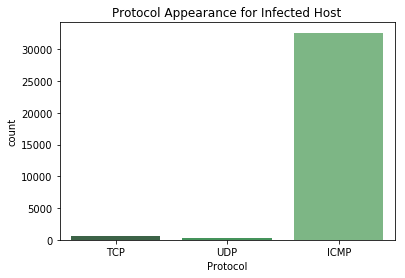

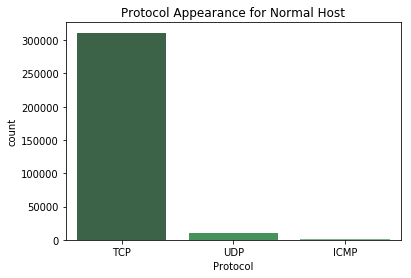

In [4]:
# investigate for the selected infected host which features are more discriminative

#investigate the protocol for the infected host
plt.title('Protocol Appearance for Infected Host')
sns.countplot(x="Protocol", data=dataset_infected, palette="Greens_d")
plt.figure()
#investigate the protocol for the normal hosts
plt.title('Protocol Appearance for Normal Host')
dataset_normal=dataset_clean.loc[dataset_clean['bin_lab']==1.0]
sns.countplot(x="Protocol", data=dataset_normal, palette="Greens_d")

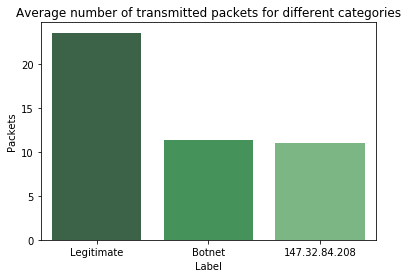

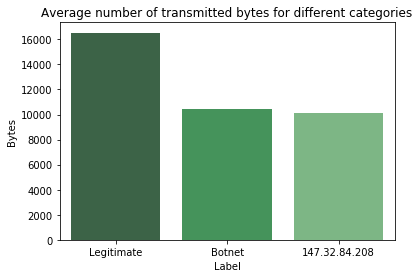

In [5]:
packets=[]
bytes=[]

# add data for normal hosts
dataset_normal=dataset_clean.loc[dataset_clean['bin_lab']==1.0]
packets.append(dataset_normal.Packet.mean())
bytes.append(dataset_normal.Bytes.mean())

# add data for botnet hosts
a=dataset_clean.loc[dataset_clean['bin_lab']==0.0]
packets.append(a.Packet.mean())
bytes.append(a.Bytes.mean())

# add data for the specific infected host
packets.append(dataset_infected.Packet.mean())
bytes.append(dataset_infected.Bytes.mean())

labels = ('Legitimate', 'Botnet', '147.32.84.208')

# construct two dataframes with the selected data
packets_frame = {'Label': labels, 'Packets': packets }
bytes_frame = {'Label': labels, 'Bytes': bytes }
packets_frame = pd.DataFrame(packets_frame)
bytes_frame = pd.DataFrame(bytes_frame)

plt.title('Average number of transmitted packets for different categories')
sns.barplot(x='Label', y = 'Packets', palette='Greens_d', data= packets_frame)

plt.figure()
plt.title('Average number of transmitted bytes for different categories')
sns.barplot(x='Label', y = 'Bytes', palette='Greens_d', data= bytes_frame)

### The discretization of the selected features begins

In [6]:
# the elbow graph to determine the optimal number of clusters
def elbow_graph(data):
    dist = []
    X=data.reshape(-1,1)
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        dist.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.plot(range(1, 10), dist)
    plt.title('Elbow rule')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.grid(True)
    plt.title('Elbow curve')

/Library/Python/2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


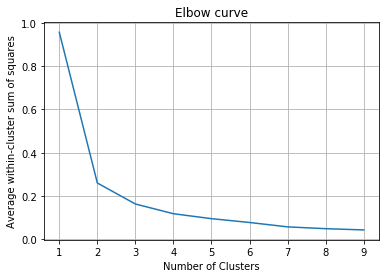

In [8]:
elbow_graph(dataset_clean['Packet'])

In [9]:
# function to find the ordinal rank based on the Pellegrino et al. paper
def ordinal_rank(bins,col_name):
    percentile = 100/bins
    split_list = []

    for p in range(percentile, 99, percentile):
        rank = math.ceil((p/100.0)*len(dataset_clean[col_name])*1.0)
        val = sorted(dataset_clean[col_name])[int(rank)]
        split_list.append(val)
    return split_list

In [10]:
#for the data from all hosts
split_list_Packets = ordinal_rank(4,'Packet')

In [11]:
def attribute_mapping(x, split_list):
    for i,s in enumerate(split_list):
        if x<=s:
            return i
    return len(split_list)

In [12]:
def netflow_encoding(netflow, feature_space):
    code = 0
    space_size = feature_space[0]*feature_space[1]
    for i in range (0,len(feature_space)):
        code = code + (netflow[i]) * space_size / feature_space[i]
        space_size = space_size / feature_space[i]
    return code

In [13]:
# discretize the infected dataframe

d_discr_infected = pd.DataFrame()
d_discr_infected['Packet'] = dataset_infected['Packet'].apply(lambda x: attribute_mapping(x,split_list_Packets))

d_discr_infected['Protocol'] = pd.factorize(dataset_infected['Protocol'])[0]

feature_space = [d_discr_infected[name].nunique() for name in d_discr_infected.columns[0:2]]
d_discr_infected['code'] = d_discr_infected.apply(lambda x: netflow_encoding(x, feature_space),axis=1)

In [14]:
# discritize the initial dataframe

d_discr = pd.DataFrame()
d_discr['Packet'] = dataset_clean['Packet'].apply(lambda x: attribute_mapping(x,split_list_Packets))

d_discr['Protocol'] = pd.factorize(dataset_clean['Protocol'])[0]

feature_space = [d_discr[name].nunique() for name in d_discr.columns[0:2]]
d_discr['code'] = d_discr.apply(lambda x: netflow_encoding(x, feature_space),axis=1)
dataset_clean['code'] = d_discr['code']

d_discr['Source'] = dataset_clean['Source']
d_discr['Dest'] = dataset_clean['Dest']
d_discr['StartTime'] = dataset_clean['StartTime']

# The Botnet Profiling Task starts here.....

In [15]:
def extract_state(host_data,width):
    start_time = host_data['StartTime']
    difference_list = []
    for i in range(len(host_data)):
        if i == 0:
            difference = 0
        else:
            difference = start_time.iloc[i]-start_time.iloc[i-1]
            difference = np.ceil(difference.value/1e6)
        difference_list.append(difference)
    host_data['time'] = difference_list
            
    # keep the hosts in the specified sliding window
    state_list = []
    for i in range(len(host_data)):
        j = i
        state_list.append([])
        temp_list = [host_data['code'].iloc[j]]
        time_sum = 0
        while True:
            try:
                time_sum += difference_list[j+1]
            except:
                break
            j += 1
            if time_sum<=width:
                temp_list.append(host_data['code'].iloc[j])
            else:
                break
        if len(temp_list)>=3:
            state_list[i] = temp_list
    host_data['window_states'] = state_list
    return host_data

In [16]:
# apply the n-grams sequencial model

def find_ngrams(states, n):
    ngrams = []
    for state in states:
        for s in range(len(state)-n+1):
            ngrams.append(state[s:s+n])    
    return ngrams

In [17]:
def sort_ngrams(grams3_normals):
    ngram_dict = {}
    for gram in grams3_normals :
        grams = str(gram)[1:-1]
        if grams in ngram_dict:
            ngram_dict[grams] += 1
        else:
            ngram_dict[grams] = 1 
    sorted_ngrams = sorted(ngram_dict.items(),key = lambda x:x[1], reverse = True )
    sortedgrams_normed = [ (list[0], 1.0*list[1]/len(grams3_normals)) for list in sorted_ngrams]
    return sortedgrams_normed

### Define which two ips (one for botnet, one for normal) that will be used as training and the rest will be used as testing set

In [18]:
# we define one normal host as "train" set
# for the botnet we will used the infected_host defined above
normal_host = '147.32.84.170'

test_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204',
             '147.32.84.205','147.32.84.206','147.32.84.207','147.32.84.209', '147.32.84.134', 
              '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

In [19]:
# fingerprinting the normal host used as train
train_normal = d_discr[(d_discr['Source'] == normal_host) | (d_discr['Dest'] == normal_host)]
train_normal_states = extract_state(train_normal, width=90)
train_normal_states = [l for l in train_normal_states['window_states'] if len(l)>0]
train_normal_ngrams = find_ngrams(train_normal_states, 2)
train_normal = sort_ngrams(train_normal_ngrams)


# fingerprinting the infected host used as train
train_infected = d_discr[(d_discr['Source'] == infected_host) | (d_discr['Dest'] == infected_host)]
train_infected_states = extract_state(train_infected, width=90)
train_infected_states = [l for l in train_infected_states['window_states'] if len(l)>0]
train_infected_ngrams = find_ngrams(train_infected_states, 2)
train_infected = sort_ngrams(train_infected_ngrams)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Python/2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
def fingerprint_matching(finger_train, finger_test, topN):
    finger_train = finger_train[0:topN]
    freq_train = [pair[1] for pair in finger_train]
    
    finger_test = {pair[0]:pair[1] for pair in finger_test}
    fre_test = []
    for i in range(topN):
        key = finger_train[i][0]
        if key in finger_test:
            fre_test.append(finger_test[key])
        else:
            fre_test.append(0)  
    dis = distance(freq_train,fre_test)
    return dis

In [21]:
def distance(finger_train, finger_test):
    finger_train = np.array(finger_train)
    finger_test = np.array(finger_test)
    dis = sum((np.divide((finger_train-finger_test),(finger_train+finger_test)/2))**2)
    return dis

In [22]:
fmatch_test= np.zeros((len(test_hosts),2))

for index, host in enumerate(test_hosts):
    test_data = d_discr[(d_discr['Source'] == host) | (d_discr['Dest'] == host)]
    test_states = extract_state(test_data,width=90)
    test_states = [l for l in test_states['window_states'] if len(l)>0]
    test_ngrams = find_ngrams(test_states, 2)
    test_fingerprint = sort_ngrams(test_ngrams)
    fmatch_test[index][0] = fingerprint_matching(train_infected,test_fingerprint,10)    
    fmatch_test[index][1] = fingerprint_matching(train_normal,test_fingerprint,10)   

/Library/Python/2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Python/2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Single Scenario Simulation

In [23]:
test_label = np.zeros(14)
for i in range(14):
        if fmatch_test[i][0] <= fmatch_test[i][1]:
            test_label[i] = 1
        else:
            test_label[i] = 0

true_label = [1,1,1,1,1,1,1,1,1,0,0,0,0,0]

tn, fp, fn, tp = confusion_matrix(test_label, true_label).ravel()


print 'precision:', float(tp)/(tp+fp)
print 'recall', float(tp)/(tp+fn) 

precision: 1.0
recall 0.9


### Multi Scenario Simulation

for this case we will use both Scenario 9, 10. Train set is the scenario 10 and test set the scenario 9.

In [24]:
lst=[]
with open('capture20110817.pcap.netflow.labeled') as fp:  
    for cnt, line in enumerate(fp):
        k=[]
        if cnt!=0:
            dat=line.split("\t")
            if len(dat)>=13:
                for d in dat:
                    d.strip()
                    if len(d)==0:
                        k = dat.remove(d)
            if len(dat)>=3:
                dat[3] = dat[3].split(':')[0]
            if len(dat)>=5:
                dat[5] = dat[5].split(':')[0]
            if k:
                lst.append(k)
            else: lst.append(dat)
dataset_test=pd.DataFrame(lst, columns=columns)

In [25]:
dataset_test = dataset.loc[(dataset['Label']!="Background\n")]
dataset_test = dataset_test.reset_index(drop=True)
dataset_test['StartTime'] = pd.to_datetime(dataset_test['StartTime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [26]:
d_discr_multi = pd.DataFrame()
# d_discr['Duration'] = dataset_clean['Duration'].apply(lambda x: attribute_mapping(x,split_list_Duration))
d_discr_multi['Packet'] = dataset_test['Packet'].apply(lambda x: attribute_mapping(x,split_list_Packets))

d_discr_multi['Protocol'] = pd.factorize(dataset_test['Protocol'])[0]

d_discr_multi['code'] = d_discr_multi.apply(lambda x: netflow_encoding(x, feature_space),axis=1)
dataset_clean['code'] = d_discr_multi['code']

d_discr_multi['Source'] = dataset_test['Source']
d_discr_multi['Dest'] = dataset_test['Dest']
d_discr_multi['StartTime'] = dataset_test['StartTime']

In [27]:
multi_test_ips = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193', 
                  '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.207', '147.32.84.208', 
                  '147.32.84.209', '147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36',
                 '147.32.80.9', '147.32.87.11']

multi_test_ips_labels = [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0]

In [28]:
train_normal2 = d_discr[(d_discr['Source'] == test_hosts[10]) | (d_discr['Dest'] == test_hosts[10])]
train_normal_states2 = extract_state(train_normal2, width=90)
train_normal_states2 = [l for l in train_normal_states2['window_states'] if len(l)>0]
train_normal_ngrams2 = find_ngrams(train_normal_states2, 2)
train_normal2 = sort_ngrams(train_normal_ngrams2)



train_infected2 = d_discr[(d_discr['Source'] == test_hosts[0]) | (d_discr['Dest'] == test_hosts[0])]
train_infected_states2 = extract_state(train_infected2, width=90)
train_infected_states2 = [l for l in train_infected_states2['window_states'] if len(l)>0]
train_infected_ngrams2 = find_ngrams(train_infected_states2, 2)
train_infected2 = sort_ngrams(train_infected_ngrams2)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Python/2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
multi_fmatch_test= np.zeros((len(multi_test_ips),2))

for index, host in enumerate(multi_test_ips):
    test_data = d_discr_multi[(d_discr_multi['Source'] == host) | (d_discr_multi['Dest'] == host)]
    test_states = extract_state(test_data,width=90)
    test_states = [l for l in test_states['window_states'] if len(l)>0]
    test_ngrams = find_ngrams(test_states, 2)
    test_fingerprint = sort_ngrams(test_ngrams)
    multi_fmatch_test[index][0] = fingerprint_matching(train_infected,test_fingerprint,10)    
    multi_fmatch_test[index][1] = fingerprint_matching(train_normal,test_fingerprint,10)   


/Library/Python/2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Python/2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
test_label = np.zeros(16)
for i in range(16):
        if multi_fmatch_test[i][0] <= multi_fmatch_test[i][1]:
            test_label[i] = 1
        else:
            test_label[i] = 0

tn, fp, fn, tp = confusion_matrix(test_label, multi_test_ips_labels).ravel()

print 'precision:', float(tp)/(tp+fp)
print 'recall', float(tp)/(tp+fn) 

precision: 1.0
recall 0.714285714286
